/usr/local/lib/python3.7/dist-packages/control/timeresp.py:918: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  "return_x specified for a transfer function system. Internal "
/usr/local/lib/python3.7/dist-packages/control/timeresp.py:924: UserWarning: Non-zero initial condition given for transfer function system. Internal conversion to state space used; may not be consistent with given X0.
  "Non-zero initial condition given for transfer function system. "


PIDNN - TS: 10.62 s - TR: 10.02 s - OV: 4.19%
Classic PID - TS: 11.06 s - TR: 10.10 s - OV: 16.81%


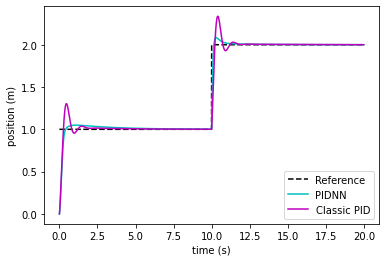

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import math
import control.matlab
from typing import Any

#from plants.motor_position import MotorPosition
#from utils.evaluator import *
#from controllers.pidnn import PIDNN
#from controllers.pid import PID
class PID(object):
    """
        Classic PID Controller
    """
    def __init__(
        self,
        constants: tuple,
        timestep: float) -> None:
        # Timestep
        self.timestep = timestep

        # Hidden layer connection weights
        self.hidden_weights = np.array([[-1, -1, -1], [1, 1, 1]], dtype=float)
        # Output layer connection weights
        self.output_weights = np.array(constants, dtype=float)

        # Indexed according to [t, t - 1]
        # System feedback vector
        self.y = np.zeros([2], dtype=float)
        # Reference vector
        self.r = np.zeros([2], dtype=float)

        # Feedback input vector
        self.input_y = np.zeros([2], dtype=float)
        # Reference input vector
        self.input_r = np.zeros([2], dtype=float)

        # Hidden layer inputs
        self.hidden_input_p = np.zeros([2], dtype=float)
        self.hidden_input_i = np.zeros([2], dtype=float)
        self.hidden_input_d = np.zeros([2], dtype=float)

        # Hidden layer outputs
        self.hidden_output_p = np.zeros([2], dtype=float)
        self.hidden_output_i = np.zeros([2], dtype=float)
        self.hidden_output_d = np.zeros([2], dtype=float)

        # Control effort vector
        self.v = np.zeros([2], dtype=float)

    def p_transfer_function(self, v: float) -> float:
        return v

    def i_transfer_function(self, v: float, accumulated_v: float) -> float:
        return v * self.timestep + accumulated_v

    def d_transfer_function(self, v: float, past_v: float) -> float:
        return (v - past_v) / self.timestep

    def predict(self, reference: float, feedback: float) -> float:
        # Update variable history
        self.y[1] = self.y[0]
        self.r[1] = self.r[0]
        self.y[0] = feedback
        self.r[0] = reference

        self.input_y[1] = self.input_y[0]
        self.input_r[1] = self.input_r[0]
        self.hidden_input_p[1] = self.hidden_input_p[0]
        self.hidden_input_i[1] = self.hidden_input_i[0]
        self.hidden_input_d[1] = self.hidden_input_d[0]
        self.hidden_output_p[1] = self.hidden_output_p[0]
        self.hidden_output_i[1] = self.hidden_output_i[0]
        self.hidden_output_d[1] = self.hidden_output_d[0]

        self.v[1] = self.v[0]

        # Calculate input neuron outputs
        self.input_y[0] = self.p_transfer_function(feedback)
        self.input_r[0] = self.p_transfer_function(reference)

        # Calculate hidden P neurons outputs
        self.hidden_input_p[0] = (
            self.input_y[0] * self.hidden_weights[0][0]
            + self.input_r[0] * self.hidden_weights[1][0])
        self.hidden_output_p[0] = self.p_transfer_function(self.hidden_input_p[0])

        # Calculate hidden I neurons outputs
        self.hidden_input_i[0] = (
            self.input_y[0] * self.hidden_weights[0][1]
            + self.input_r[0] * self.hidden_weights[1][1])
        self.hidden_output_i[0] = self.i_transfer_function(
            self.hidden_input_i[0], self.hidden_output_i[1])

        # Calculate hidden D neurons outputs
        self.hidden_input_d[0] = (
            self.input_y[0] * self.hidden_weights[0][2]
            + self.input_r[0] * self.hidden_weights[1][2])
        self.hidden_output_d[0] = self.d_transfer_function(
            self.hidden_input_d[0], self.hidden_input_d[1])

        # Calculate output neuron outputs
        self.v[0] = (
            self.hidden_output_p[0] * self.output_weights[0]
            + self.hidden_output_i[0] * self.output_weights[1]
            + self.hidden_output_d[0] * self.output_weights[2])

        return self.v[0]
class PIDNN(object):
    """
        Adaptive PID Neural Network Controller
    """
    def __init__(
        self,
        initial_constants: tuple,
        learning_rate: float,
        max_weight_change: float,
        tolerance: float,
        timestep: float) -> None:
        # The network learning rate
        self.eta = learning_rate
        # Error tolerance
        self.tol = tolerance
        # Maximum weight change
        self.max_weight_chg = max_weight_change
        # Maximum tolerance for weight change
        self.weight_chg_tol = self.max_weight_chg * math.log(2) / self.eta
        # Division by zero tolerance
        self.div_by_zero_tol = 1e-20
        # Timestep
        self.timestep = timestep

        # Hidden layer connection weights
        self.hidden_weights = np.array([[-1, -1, -1], [1, 1, 1]], dtype=float)
        # Output layer connection weights
        self.output_weights = np.array(initial_constants, dtype=float)

        # Indexed according to [t, t - 1]
        # System feedback vector
        self.y = np.zeros([2], dtype=float)
        # Reference vector
        self.r = np.zeros([2], dtype=float)

        # Feedback input vector
        self.input_y = np.zeros([2], dtype=float)
        # Reference input vector
        self.input_r = np.zeros([2], dtype=float)

        # Hidden layer inputs
        self.hidden_input_p = np.zeros([2], dtype=float)
        self.hidden_input_i = np.zeros([2], dtype=float)
        self.hidden_input_d = np.zeros([2], dtype=float)

        # Hidden layer outputs
        self.hidden_output_p = np.zeros([2], dtype=float)
        self.hidden_output_i = np.zeros([2], dtype=float)
        self.hidden_output_d = np.zeros([2], dtype=float)

        # Control effort vector
        self.v = np.zeros([2], dtype=float)

    def threshold_div_by_zero(self, value: float) -> float:
        if math.fabs(value) < self.div_by_zero_tol:
            if value >= 0:
                return self.div_by_zero_tol
            else:
                return -self.div_by_zero_tol
        return value

    def p_transfer_function(self, v: float) -> float:
        return v

    def i_transfer_function(self, v: float, accumulated_v: float) -> float:
        return v * self.timestep + accumulated_v

    def d_transfer_function(self, v: float, past_v: float) -> float:
        return (v - past_v) / self.timestep

    def predict(self, reference: float, feedback: float) -> float:
        # Update weights
        self.learn(feedback)
        
        # Update variable history
        self.y[1] = self.y[0]
        self.r[1] = self.r[0]
        self.y[0] = feedback
        self.r[0] = reference

        self.input_y[1] = self.input_y[0]
        self.input_r[1] = self.input_r[0]
        self.hidden_input_p[1] = self.hidden_input_p[0]
        self.hidden_input_i[1] = self.hidden_input_i[0]
        self.hidden_input_d[1] = self.hidden_input_d[0]
        self.hidden_output_p[1] = self.hidden_output_p[0]
        self.hidden_output_i[1] = self.hidden_output_i[0]
        self.hidden_output_d[1] = self.hidden_output_d[0]

        self.v[1] = self.v[0]

        # Calculate input neuron outputs
        self.input_y[0] = self.p_transfer_function(feedback)
        self.input_r[0] = self.p_transfer_function(reference)

        # Calculate hidden P neurons outputs
        self.hidden_input_p[0] = (
            self.input_y[0] * self.hidden_weights[0][0]
            + self.input_r[0] * self.hidden_weights[1][0])
        self.hidden_output_p[0] = self.p_transfer_function(self.hidden_input_p[0])

        # Calculate hidden I neurons outputs
        self.hidden_input_i[0] = (
            self.input_y[0] * self.hidden_weights[0][1]
            + self.input_r[0] * self.hidden_weights[1][1])
        self.hidden_output_i[0] = self.i_transfer_function(
            self.hidden_input_i[0], self.hidden_output_i[1])

        # Calculate hidden D neurons outputs
        self.hidden_input_d[0] = (
            self.input_y[0] * self.hidden_weights[0][2]
            + self.input_r[0] * self.hidden_weights[1][2])
        self.hidden_output_d[0] = self.d_transfer_function(
            self.hidden_input_d[0], self.hidden_input_d[1])

        # Calculate output neuron outputs
        self.v[0] = (
            self.hidden_output_p[0] * self.output_weights[0]
            + self.hidden_output_i[0] * self.output_weights[1]
            + self.hidden_output_d[0] * self.output_weights[2])

        return self.v[0]

    def learn(self, feedback: float) -> None:
        # Backprop
        delta_r = self.r[0] - self.y[0]
        delta_y = feedback - self.y[0]

        delta_output_weights = self.backprop(delta_r, delta_y)

        # Update weights when error is larger than the tolerance
        if delta_r >= self.tol:
            for idx in range(delta_output_weights.shape[0]):
                if math.fabs(delta_output_weights[idx]) > self.weight_chg_tol:
                    if delta_output_weights[idx] > 0:
                        delta_output_weights[idx] = self.weight_chg_tol
                    elif delta_output_weights[idx] < 0:
                        delta_output_weights[idx] = -self.weight_chg_tol
                
                self.output_weights[idx] = self.output_weights[idx] - self.eta * delta_output_weights[idx]

    def backprop(self, delta_r: float, delta_y: float) -> Any:
        delta_v = self.threshold_div_by_zero(self.v[0] - self.v[1])

        # Output layer weight changes
        delta_output_weights = np.zeros([3], dtype=float)
        delta_output_weights[0] = (
            -2 * delta_r * delta_y * self.hidden_output_p[0] / delta_v)
        delta_output_weights[1] = (
            -2 * delta_r * delta_y * self.hidden_output_i[0] / delta_v)
        delta_output_weights[2] = (
            -2 * delta_r * delta_y * self.hidden_output_d[0] / delta_v)

        return delta_output_weights
def calc_settling_time(
        y: list(), 
        t: list(),
        settling_time_threshold = 0.02) -> float:
        steady_state_val = y[-1]
        upper_margin = (1.0 + settling_time_threshold) * steady_state_val
        lower_margin = (1.0 - settling_time_threshold) * steady_state_val

        for i in reversed(range(len(t))):
            if y[i] <= lower_margin or y[i] >= upper_margin:
                settling_time = t[i]
                break

        return settling_time 

def calc_rise_time(
    y: list(),
    t: list(),
    rise_time_lower_val_bound = 0.1,
    rise_time_upper_val_bound = 0.9) -> float:
    steady_state_val = y[-1]

    rise_time_lower_idx = (np.where(y >= rise_time_lower_val_bound * steady_state_val)[0])[0]
    rise_time_upper_idx = (np.where(y >= rise_time_upper_val_bound * steady_state_val)[0])[0]

    rise_time = t[rise_time_upper_idx] - t[rise_time_lower_idx]

    return rise_time

def calc_overshoot_percent(y: list()) -> float:
    steady_state_val = y[-1]
    overshoot_val = max(y) / steady_state_val - 1
    overshoot_percent = overshoot_val * 100

    return overshoot_percent
class MotorPosition:
    """
        Motor position plant model
    """
    def __init__(self, K: float, tau: float) -> None:
        # System characteristics
        self._K = K
        self._tau = tau
        self._G = control.matlab.TransferFunction([K], [tau, 1, 0])

        # System state
        self._X = 0.0
        self._U = np.array([0.0])
        self._T = np.array([0.0])

    def reset_states(self) -> None:
        self._X = 0.0
        self._U = np.array([0.0])
        self._T = np.array([0.0])

    def simulate_one_step(self, U_input: float, T_input: float) -> float:
        self._T = np.array([self._T[-1], T_input])
        self._U = np.array([self._U[-1], U_input])
        y, _, x = control.matlab.lsim(self._G, self._U, self._T, X0 = self._X)
        self._X = x[-1]

        return y[-1]
# Simulation parameters
t_end = 20
d_t = 0.01
T = np.arange(0.0, t_end, d_t)
it = np.nditer(T, flags=['f_index'])
r = np.full_like(T, 1.0)

num_changes = 2
interval = int(len(T) / num_changes)

for i in range(num_changes):
    r[i * interval:(i + 1) * interval] = i + 1

# Motor position model
plant = MotorPosition(
    K = 1, 
    tau = 0.5)

# Kp, Ki, Kd
constants = [22.34, 7.579, 1.956]

# PIDNN Controller
pidnn = PIDNN(
    initial_constants = constants,
    learning_rate = 1, 
    max_weight_change = 100, 
    tolerance = 1e-8,
    timestep = d_t)

pid = PID(
    constants = constants,
    timestep = d_t)

# Simulate response
y_pidnn = [0.0]
y_pid = [0.0]

# Adaptive
plant.reset_states()
it.reset()
for i in it:
    u = pidnn.predict(reference = r[it.index], feedback = y_pidnn[-1])
    y_pidnn.append(plant.simulate_one_step(u, i))

# Non-adaptive
plant.reset_states()
it.reset()
for i in it:
    u = pid.predict(reference = r[it.index], feedback = y_pid[-1])
    y_pid.append(plant.simulate_one_step(u, i))

# Tweak lengths to match the time series
y_pidnn = y_pidnn[1:]
y_pid = y_pid[1:]

# Performance metrics
settling_time_pidnn = calc_settling_time(y_pidnn, T)
rise_time_pidnn = calc_rise_time(y_pidnn, T)
overshoot_pidnn = calc_overshoot_percent(y_pidnn)

settling_time_pid = calc_settling_time(y_pid, T)
rise_time_pid = calc_rise_time(y_pid, T)
overshoot_pid = calc_overshoot_percent(y_pid)

print("PIDNN - TS: {:.2f} s - TR: {:.2f} s - OV: {:.2f}%".format(
    settling_time_pidnn, 
    rise_time_pidnn, 
    overshoot_pidnn))

print("Classic PID - TS: {:.2f} s - TR: {:.2f} s - OV: {:.2f}%".format(
    settling_time_pid, 
    rise_time_pid, 
    overshoot_pid))

# Plot the results
plt.plot(T, r, 'k--', label = 'Reference')
plt.plot(T, y_pidnn, 'c', label = 'PIDNN')
plt.plot(T, y_pid, 'm', label = 'Classic PID')
plt.xlabel('time (s)')
plt.ylabel('position (m)')
plt.legend(loc = 'lower right', shadow = False, fontsize = 'medium')
plt.show(block = True)

In [3]:
!pip install control

     |████████████████████████████████| 357 kB 5.2 MB/s 
  Created wheel for control: filename=control-0.9.1-py2.py3-none-any.whl size=364703 sha256=f248f376564ddd285e190d6d11856a3ae6bf17a43f3bc41ddc08cfa3a8d458a2
  Stored in directory: /root/.cache/pip/wheels/b1/50/22/8005107713828997d1af664fbd629c7f935a1b87fc2f4ba6c1
Successfully built control
